In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv('feature_extraction.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   xeploai_tt            35849 non-null  int64  
 2   hocky                 35849 non-null  int64  
 3   namhoc                35849 non-null  int64  
 4   drltl                 35849 non-null  int64  
 5   sotchk                35849 non-null  int64  
 6   dtbhk_truoc           35849 non-null  float64
 7   xeploai               35849 non-null  int64  
 8   khuvuc_encoded        35849 non-null  int64  
 9   namnhaphoc            35849 non-null  int64  
 10  chuyennganh2_encoded  35849 non-null  float64
 11  hedt_encoded          35849 non-null  int64  
 12  khoa_encoded          35849 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 3.6 MB


#Feature Selection

## Filter method (Mutual Information)

In [4]:
features = df.drop(columns=['xeploai'])
target = df['xeploai']

In [5]:
mi_target = mutual_info_classif(features, target)

In [6]:
mi_target_df = pd.DataFrame({
    'Feature': features.columns,
    'Mutual Information': mi_target
})
mi_target_df = mi_target_df.sort_values(by='Mutual Information', ascending=False)
mi_target_df

,Feature,Mutual Information
6,dtbhk_truoc,0.363408
4,drltl,0.223834
5,sotchk,0.038972
10,hedt_encoded,0.035147
3,namhoc,0.035093
9,chuyennganh2_encoded,0.023515
8,namnhaphoc,0.021637
1,xeploai_tt,0.015416
0,gioitinh,0.015259
11,khoa_encoded,0.010691


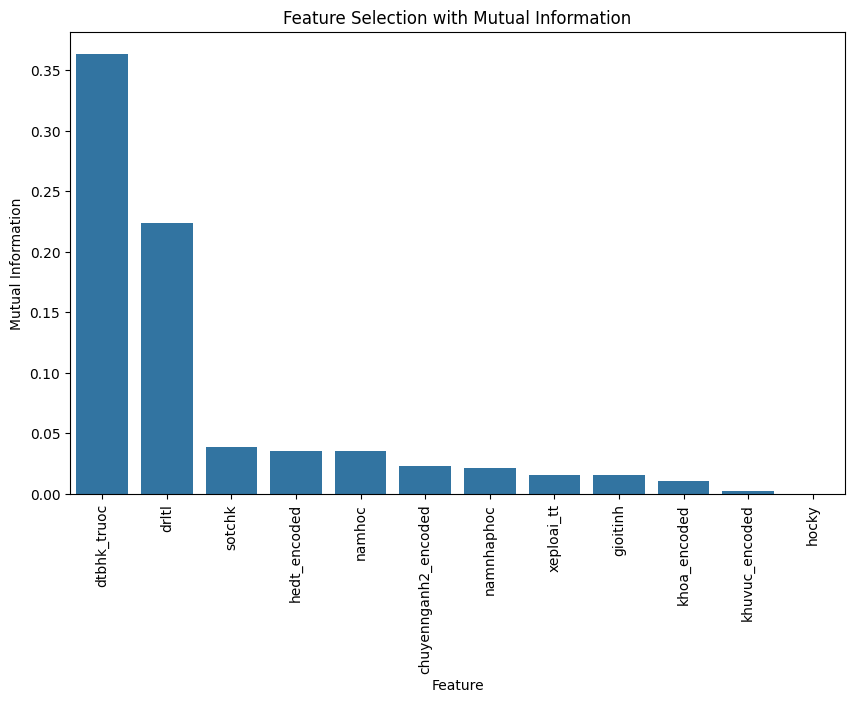

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Mutual Information', data=mi_target_df)
plt.xticks(rotation=90)
plt.title('Feature Selection with Mutual Information')
plt.show()

Có thể thấy dtbhk_truoc là thuộc tính quyết định đến xeploai, các thuộc tính tiếp theo như drltl, sotchk, hedt, namhoc (MI > 0.02). Ta tiếp tục thực hiện phân tích sâu hơn các biến này:

In [8]:
features = df[['dtbhk_truoc', 'drltl', 'sotchk', 'hedt_encoded', 'namhoc']]

In [9]:
#Tính mối quan hệ MI giữa các cặp với nhau
mi_feature_pairs = pd.DataFrame(columns=features.columns, index=features.columns)
for feature1 in features.columns:
    for feature2 in features.columns:
        if feature1 != feature2:
            mi_value = mutual_info_classif(features[[feature1, feature2]], target)
            mi_feature_pairs.loc[feature1, feature2] = mi_value[0]
mi_feature_pairs

,dtbhk_truoc,drltl,sotchk,hedt_encoded,namhoc
dtbhk_truoc,NaN,0.363736,0.363673,0.360794,0.365724
drltl,0.2262,NaN,0.235779,0.223151,0.23246
sotchk,0.03355,0.035792,NaN,0.04116,0.037291
hedt_encoded,0.034327,0.03326,0.033366,NaN,0.034242
namhoc,0.03448,0.033015,0.030952,0.030738,NaN


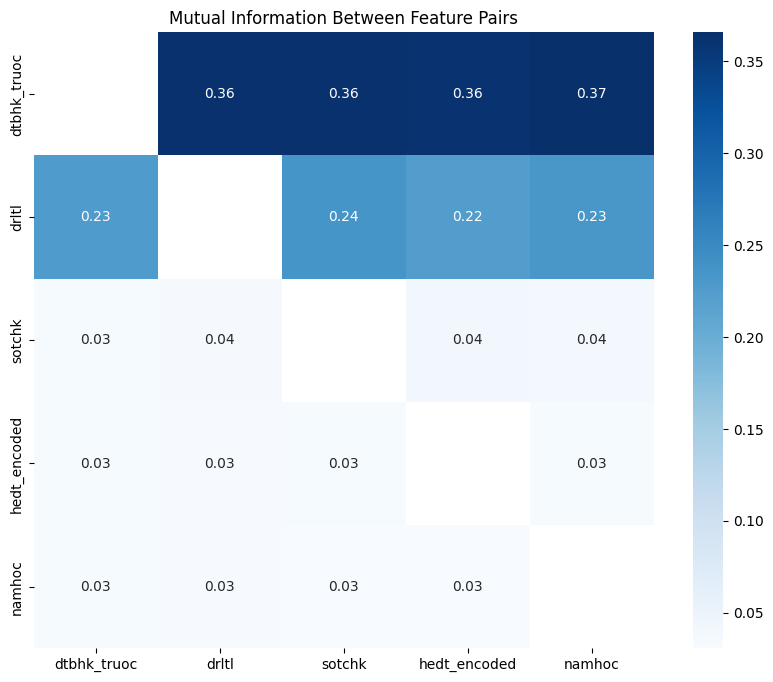

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(mi_feature_pairs.astype(float), annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title('Mutual Information Between Feature Pairs')
plt.show()

Do dtbhk_truoc và namhoc có MI cao (0.37), chứng tỏ đây là một cặp có quan hệ chặt chẽ. Bên cạnh đó sotchk và drltl cũng có MI cao hơn so với các cặp quan hệ khác (0.04)

## Phân tích mối liên hệ giữa dtbhk_truoc và namhoc

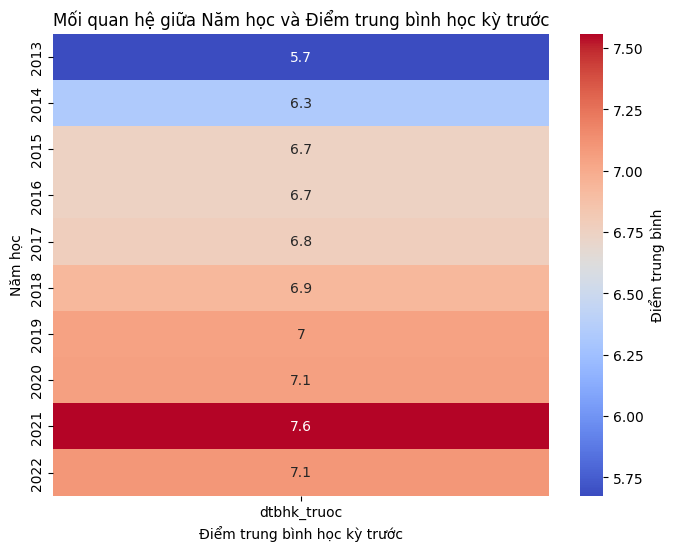

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo Pivot Table
pivot = df.pivot_table(index='namhoc', values='dtbhk_truoc', aggfunc='mean')

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Điểm trung bình'})
plt.title('Mối quan hệ giữa Năm học và Điểm trung bình học kỳ trước')
plt.xlabel('Điểm trung bình học kỳ trước')
plt.ylabel('Năm học')
plt.show()


Dựa vào hình trên, có thể thấy rõ xu hướng quan hệ tuyến tính giữa 2 biến này theo từng năm. Cụ thể, trong những năm gần đây, dtbhktruoc có xu hướng tăng dần, với các giá trị cao hơn so với các năm trước đó. Đây có thể phản ánh sự cải thiện trong chất lượng học tập của sinh viên qua các năm. Có thể chứng minh rõ ràng hơn qua việc phân khoảng các năm và thể hiện ở biểu đồ phân tán dưới đây

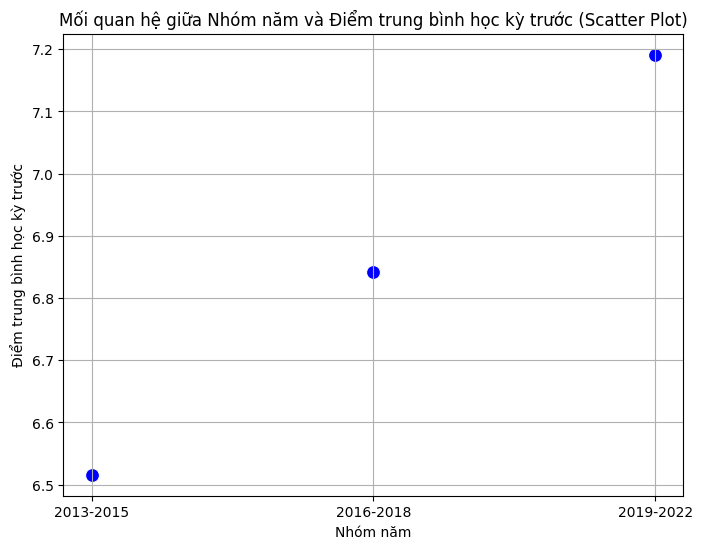

In [12]:
df1 = df.copy()

# Thêm cột "Nhóm năm" để phân nhóm các năm
bins = [2013, 2015, 2018, 2022]
labels = ['2013-2015', '2016-2018', '2019-2022']
df1['nhom_nam'] = pd.cut(df['namhoc'], bins=bins, labels=labels, right=True)

# Tạo Pivot Table để tính điểm trung bình theo nhóm năm
pivot = df1.pivot_table(index='nhom_nam', values='dtbhk_truoc', aggfunc='mean')

pivot_reset = pivot.reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pivot_reset, x='nhom_nam', y='dtbhk_truoc', s=100, color='blue', marker='o')

plt.title('Mối quan hệ giữa Nhóm năm và Điểm trung bình học kỳ trước (Scatter Plot)')
plt.xlabel('Nhóm năm')
plt.ylabel('Điểm trung bình học kỳ trước')
plt.grid(True)
plt.show()

Ngoài ra, nhóm cũng thực hiện kiểm định Chisquare để chứng minh liên hệ giữa 2 biến

In [13]:
dtb_contingency = pd.crosstab(df['dtbhk_truoc'], df['namhoc'])

dtb_chi2, dtb_p, _, _ = chi2_contingency(dtb_contingency)

{
    "chi2_statistic": dtb_chi2,
    "p_value": dtb_p
}


{'chi2_statistic': 14129.254850515426, 'p_value': 3.6682185101371154e-267}

In [14]:
def cramers_v(chi2, n, dof):
    return np.sqrt(chi2 / (n * dof))

n = df.shape[0]
dtb_dof = dtb_contingency.shape[0] - 1

dtb_cramers_v = cramers_v(dtb_chi2, n, dtb_dof)

{
    "Hedt và xeploai": dtb_cramers_v
}


{'Hedt và xeploai': 0.020209587529910384}

Nhận xét: p_value < 0.5 (mức ý nghĩa) cho thấy namhoc ảnh hưởng đến dtbhktruoc, bên cạnh đó chỉ số cramer v nhằm đo mức độ mạnh yếu của các liên kết với chỉ số 0.02 cho thấy mối liên hệ khá mạnh ở 2 biến này

## Phân tích mối liên hệ giữa sotchk và drltl

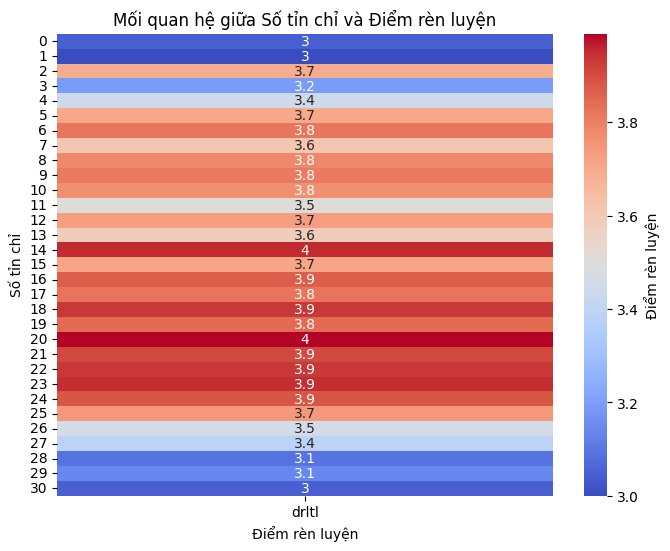

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo Pivot Table
pivot = df.pivot_table(index='sotchk', values='drltl', aggfunc='mean')

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Điểm rèn luyện'})
plt.title('Mối quan hệ giữa Số tỉn chỉ và Điểm rèn luyện')
plt.xlabel('Điểm rèn luyện')
plt.ylabel('Số tỉn chỉ')
plt.show()


Dựa vào hình trên, có thể thấy rõ xu hướng quan hệ giữa 2 biến này. Cụ thể:
- Ở mức độ tín chỉ đạt ngưỡng quy định thông thường của chương trình đào tạo (từ 14 đến 24), điểm rèn luyện thường ở mức cao nhất, đa phần nằm ở xếp loại tốt.
- Trong khi đó, các khoảng nằm ngoài (>24 và <14) lại có drltl thấp hơn, có thể là do sinh viên không tập trung học đủ số lượng môn hoặc quá tải dẫn kết quả học tập kỳ trước thước, ảnh hưởng đến điểm rèn luyện kỳ này.
- Có thể chứng minh rõ ràng hơn qua việc phân khoảng các năm và thể hiện ở biểu đồ phân tán dưới đây

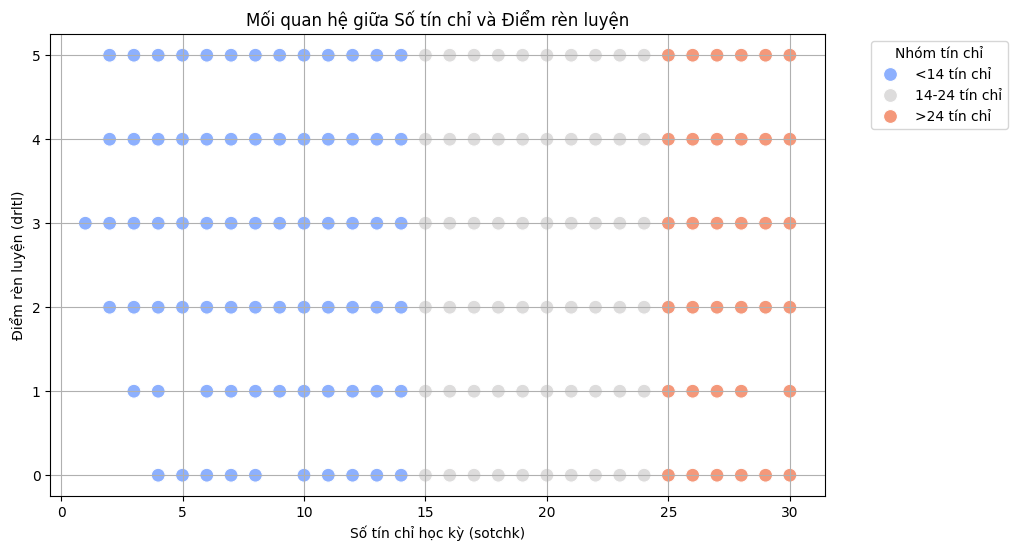

In [16]:
df1 = df.copy()

bins = [0, 14, 24, float('inf')]  # Các nhóm tín chỉ
labels = ['<14 tín chỉ', '14-24 tín chỉ', '>24 tín chỉ']  # Nhãn nhóm tín chỉ
df1['nhom_tinchi'] = pd.cut(df1['sotchk'], bins=bins, labels=labels, right=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df1, x='sotchk', y='drltl', hue='nhom_tinchi', palette='coolwarm', s=100)

plt.title('Mối quan hệ giữa Số tín chỉ và Điểm rèn luyện')
plt.xlabel('Số tín chỉ học kỳ (sotchk)')
plt.ylabel('Điểm rèn luyện (drltl)')
plt.legend(title='Nhóm tín chỉ', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [17]:
dtb_contingency = pd.crosstab(df['drltl'], df['sotchk'])

dtb_chi2, dtb_p, _, _ = chi2_contingency(dtb_contingency)

{
    "chi2_statistic": dtb_chi2,
    "p_value": dtb_p
}


{'chi2_statistic': 1109.5411669457355, 'p_value': 4.7106086336993525e-146}

In [18]:
def cramers_v(chi2, n, dof):
    return np.sqrt(chi2 / (n * dof))

n = df.shape[0]
dtb_dof = dtb_contingency.shape[0] - 1

dtb_cramers_v = cramers_v(dtb_chi2, n, dtb_dof)

{
    "Sotckhk và drltl": dtb_cramers_v
}


{'Sotckhk và drltl': 0.07867707129335524}

Nhận xét: p_value < 0.5 (mức ý nghĩa) cho thấy namhoc ảnh hưởng đến dtbhktruoc, bên cạnh đó chỉ số cramer v nhằm đo mức độ mạnh yếu của các liên kết với chỉ số 0.07 cho thấy mối liên hệ rất mạnh ở 2 biến này

# Xây dựng đồ thị mạng

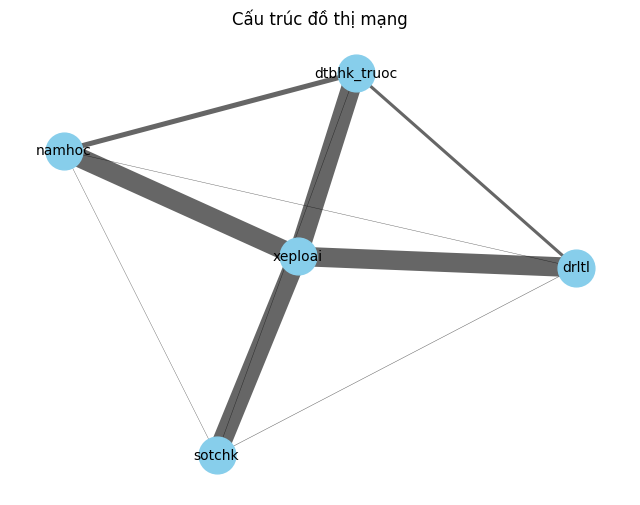

In [19]:
import networkx as nx
top_features = ['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc']
top_features_with_label = top_features + ['xeploai']
df = df[top_features_with_label]

mi_matrix = pd.DataFrame(columns=df.columns, index=df.columns)

for feature1 in df.columns:
    for feature2 in df.columns:
        if feature1 != feature2:
            mi_value = mutual_info_classif(df[[feature1, feature2]], target)
            mi_matrix.loc[feature1, feature2] = mi_value[0]

G = nx.Graph()
G.add_nodes_from(top_features_with_label)

threshold = 0.03
for i in df:
    for j in df:
        if i != j and mi_matrix.loc[i, j] > threshold:
            G.add_edge(i, j, weight=mi_matrix.loc[i, j])

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))

edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d['weight'] * 10 for (u, v, d) in edges],
    alpha=0.6
)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title("Cấu trúc đồ thị mạng")
plt.axis('off')
plt.show()


# Các phương pháp xây dựng mạng

In [20]:
df = pd.read_csv('feature_extraction.csv')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   xeploai_tt            35849 non-null  int64  
 2   hocky                 35849 non-null  int64  
 3   namhoc                35849 non-null  int64  
 4   drltl                 35849 non-null  int64  
 5   sotchk                35849 non-null  int64  
 6   dtbhk_truoc           35849 non-null  float64
 7   xeploai               35849 non-null  int64  
 8   khuvuc_encoded        35849 non-null  int64  
 9   namnhaphoc            35849 non-null  int64  
 10  chuyennganh2_encoded  35849 non-null  float64
 11  hedt_encoded          35849 non-null  int64  
 12  khoa_encoded          35849 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 3.6 MB


## Sử dụng DictVectorizer

In [22]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

df_dict = df.drop(['xeploai'], axis =1)

df_dict['dtbhk_namhoc'] = df_dict['dtbhk_truoc'] * df_dict['namhoc']
df_dict['tl'] = df_dict['sotchk'] * df_dict['drltl']

y = df['xeploai']

data_dict = df_dict.to_dict(orient='records')

vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(data_dict)

In [23]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)
xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1.0, subsample=0.9, random_state=42)
scores = cross_val_score(xgb, X, y, cv=10)
acc_xg_mean = np.mean(scores)
acc_xg_std = np.std(scores)
print(f"Mean Accuracy: {acc_xg_mean:.4f}")
print(f"Standard Deviation: {acc_xg_std:.4f}")

Mean Accuracy: 0.8978
Standard Deviation: 0.0543


## Sử dụng ma trận kề

In [24]:
import pandas as pd
import networkx as nx
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

adj_matrix = nx.adjacency_matrix(G).todense()
adj_df = pd.DataFrame(adj_matrix, columns=G.nodes, index=G.nodes)

adj_df['aggregated_connections'] = adj_df.sum(axis=1)

adj_df = adj_df.reindex(df.index, fill_value=0)

top_features = ['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc']  # Example features
df['aggregated_connections'] = adj_df['aggregated_connections']

X = df[top_features + ['aggregated_connections']]
y = df['xeploai']

X = X.dropna()
y = y.loc[X.index]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (35849, 5)
Shape of y: (35849,)


In [25]:
resampler = SMOTEENN(sampling_strategy="auto", random_state=42)
X, y = resampler.fit_resample(X, y)
xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1.0, subsample=0.9, random_state=42)
scores = cross_val_score(xgb, X, y, cv=10)
acc_xg_mean = np.mean(scores)
acc_xg_std = np.std(scores)
print(f"Mean Accuracy: {acc_xg_mean:.4f}")
print(f"Standard Deviation: {acc_xg_std:.4f}")

Mean Accuracy: 0.9487
Standard Deviation: 0.0035


## Sử dụng average pooling

In [26]:
top_features = ['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc']
top_features_with_label = top_features + ['xeploai']
df = df[top_features_with_label]

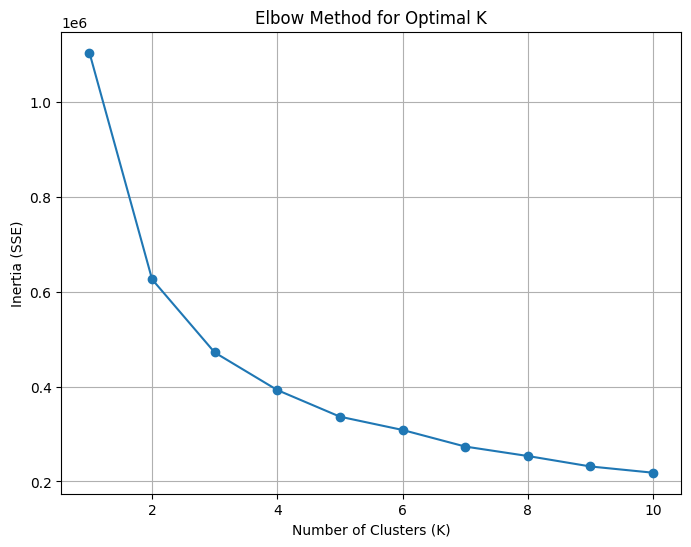

In [27]:
data = df.copy()
k_values = range(1, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[top_features])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.grid(True)
plt.show()


=> k=3

In [28]:
import networkx as nx
from sklearn.cluster import AgglomerativeClustering

def build_initial_graph(W, feature_names):
    G = nx.Graph()
    num_features = len(feature_names)
    for i, name in enumerate(feature_names):
        G.add_node(i, label=name)
    for i in range(num_features):
        for j in range(i + 1, num_features):
            if W[i, j] > 0:
                G.add_edge(i, j, weight=W[i, j])
    return G


def average_pooling_layer(data, clusters):
    pooled_data = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_data = data.iloc[:, cluster]
        pooled_data[f"Cluster_{i+1}"] = cluster_data.mean(axis=1)
    return pooled_data


def cluster_graph(G, num_clusters):
    adj_matrix = nx.to_numpy_array(G)

    clustering = AgglomerativeClustering(
        n_clusters=num_clusters, metric='precomputed', linkage='average'
    )
    cluster_labels = clustering.fit_predict(1 - adj_matrix)
    clusters = [[] for _ in range(num_clusters)]
    for node, label in enumerate(cluster_labels):
        clusters[label].append(node)
    return clusters


def hierarchical_clustering_with_pooling(data, W, feature_names, num_layers, num_clusters):
    pooled_layers = [data]
    graphs = []

    G = build_initial_graph(W, feature_names)
    graphs.append(G)

    for layer in range(num_layers):
        print(f"Building Layer {layer + 1}...")
        clusters = cluster_graph(G, num_clusters)
        pooled_data = average_pooling_layer(pooled_layers[-1], clusters)
        pooled_layers.append(pooled_data)
        G = build_initial_graph(
            np.corrcoef(pooled_data.T, rowvar=True), pooled_data.columns
        )
        graphs.append(G)

    return pooled_layers, graphs


def visualize_graph(G, title="Feature Network"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=700, font_size=10, font_color='white', font_weight='bold'
    )
    edge_colors = [d['weight'] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.viridis, width=2)
    plt.title(title)
    plt.show()


In [29]:
df = df[['dtbhk_truoc', 'drltl', 'sotchk', 'namhoc', 'xeploai']]
feature_names = df.columns.drop('xeploai').tolist()

In [32]:
scaler = StandardScaler()
standardized_features = pd.DataFrame(
        scaler.fit_transform(df[feature_names]), columns=feature_names
    )

In [33]:
correlation_matrix = np.corrcoef(standardized_features.T)
np.fill_diagonal(correlation_matrix, 0)   #loại bỏ giá trị tương quan với chính nó
num_layers = 3
num_clusters = 3
pooled_layers, graphs = hierarchical_clustering_with_pooling(
  standardized_features, correlation_matrix, feature_names, num_layers, num_clusters
)

Building Layer 1...
Building Layer 2...
Building Layer 3...


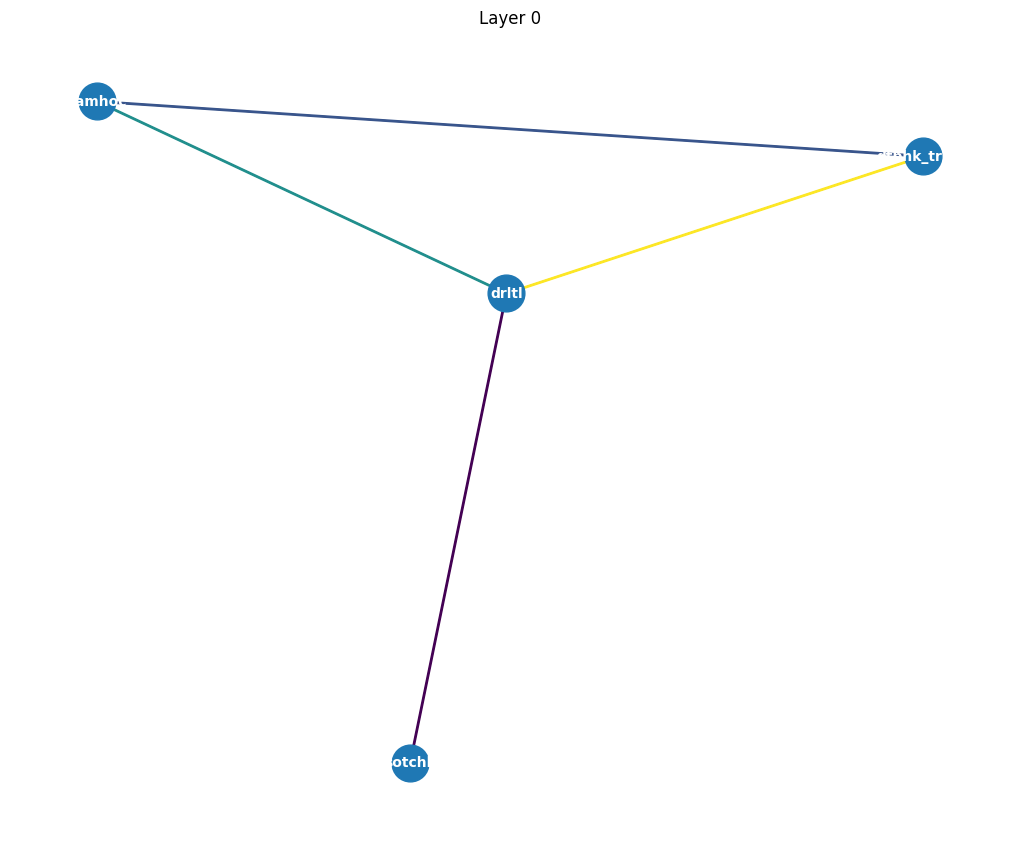

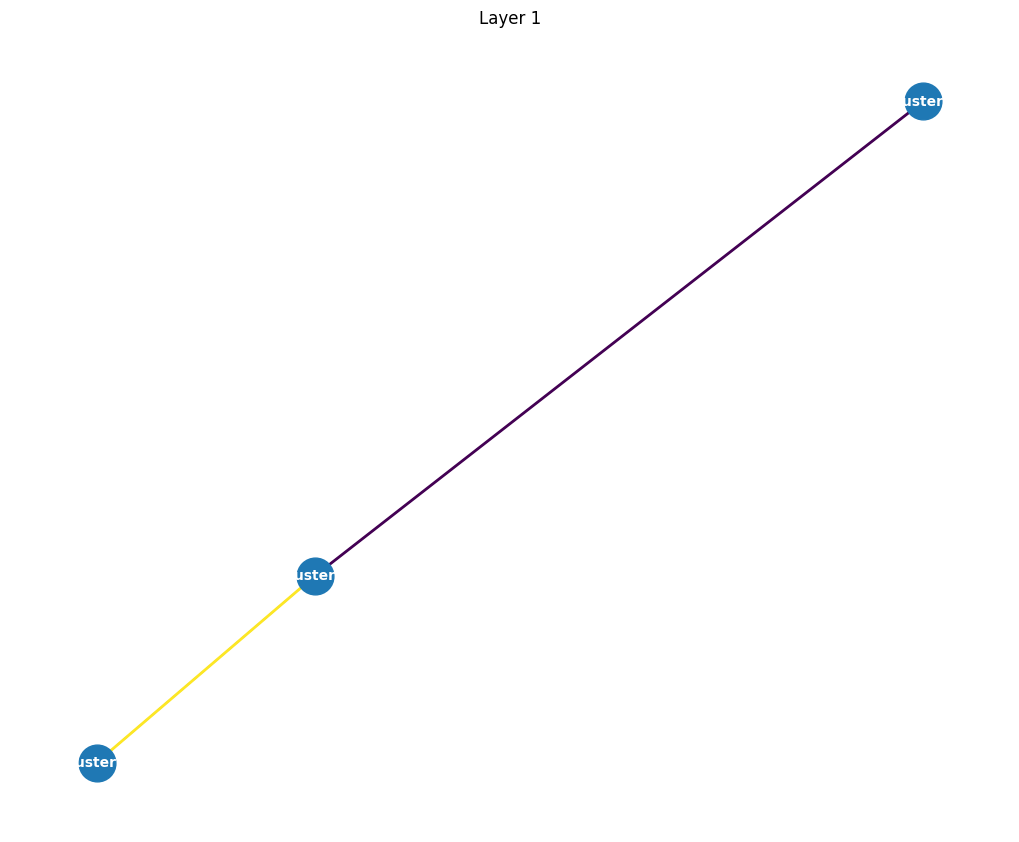

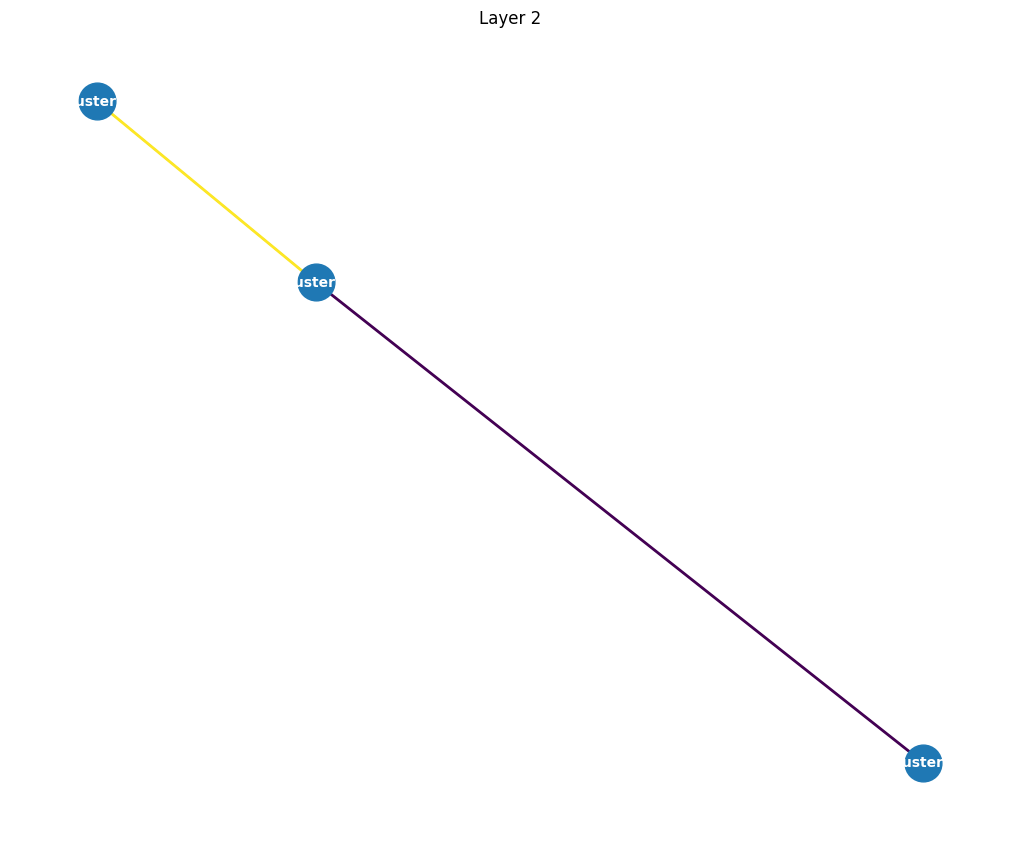

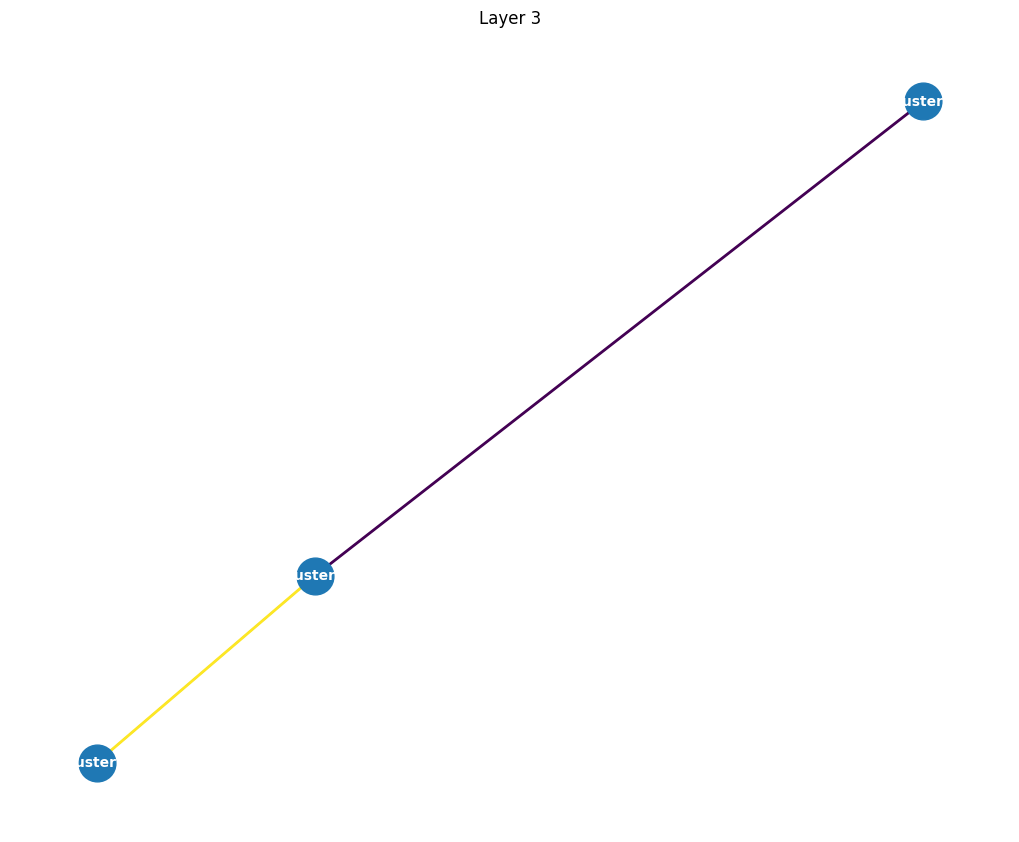

In [34]:
#Visualize
for i, G in enumerate(graphs):
        visualize_graph(G, title=f"Layer {i}")

In [35]:
#Dữ liếu sau pooling
for i, pooled_data in enumerate(pooled_layers):
  print(f"Pooled Data for Layer {i}:")
  print(pooled_data.head())

Pooled Data for Layer 0:
   dtbhk_truoc     drltl    sotchk    namhoc
0     1.065896  0.998521  0.747090  0.181935
1     1.157895  0.998521 -0.563109  0.609536
2     1.221144  0.998521  0.310357  0.609536
3     1.014147  0.998521  0.528724  1.037136
4     0.893398  0.998521  0.528724  1.037136
Pooled Data for Layer 1:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136
Pooled Data for Layer 2:
   Cluster_1  Cluster_2  Cluster_3
0   0.181935   0.747090   1.032209
1   0.609536  -0.563109   1.078208
2   0.609536   0.310357   1.109833
3   1.037136   0.528724   1.006334
4   1.037136   0.528724   0.945960
Pooled Data for Layer 3:
   Cluster_1  Cluster_2  Cluster_3
0   1.032209   0.747090   0.181935
1   1.078208  -0.563109   0.609536
2   1.109833   0.310357   0.609536
3   1.006334   0.528724   1.037136
4   0.945960   0.528724   1.037136


In [36]:
xgb = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=1.0, subsample=0.9, random_state=42)

# acc_xg = sum(cross_val_score(xgb, X, y, cv=10)) / 10
# print(f"Accuracy: {acc_xg}")
scores = cross_val_score(xgb, X, y, cv=10)
acc_xg_mean = np.mean(scores)
acc_xg_std = np.std(scores)
print(f"Mean Accuracy: {acc_xg_mean:.4f}")
print(f"Standard Deviation: {acc_xg_std:.4f}")


Mean Accuracy: 0.9487
Standard Deviation: 0.0035
